# Forecast Model for Precipitation
Created by. Elianneth Cabrera
11/07/2023

In [86]:
#importing libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from neuralprophet import NeuralProphet

In [9]:
#loading the data
data = pd.read_csv('https://raw.githubusercontent.com/OmdenaAI/myanmar-weather-forecasting/main/data/weather/open_meteo.csv?token=GHSAT0AAAAAACDV6JUF4GWAEL22X44I67IOZFPENJA')

data.head()

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,2010-01-01,1,30.3,17.2,23.5,31.5,17.7,23.9,2010-01-01T00:04,2010-01-01T11:13,...,0.0,9.3,18.7,316,4.14,16.800003,96.20001,12.0,Myanmar,Yangoon
1,2010-01-02,1,30.9,16.8,23.6,30.6,16.6,23.4,2010-01-02T00:04,2010-01-02T11:13,...,0.0,12.8,27.7,342,4.77,16.800003,96.20001,12.0,Myanmar,Yangoon
2,2010-01-03,1,30.7,17.7,23.5,30.1,16.1,22.6,2010-01-03T00:05,2010-01-03T11:14,...,0.0,13.3,26.6,338,4.96,16.800003,96.20001,12.0,Myanmar,Yangoon
3,2010-01-04,3,30.8,17.6,24.2,30.7,16.8,24.2,2010-01-04T00:05,2010-01-04T11:14,...,0.0,12.1,25.6,327,4.57,16.800003,96.20001,12.0,Myanmar,Yangoon
4,2010-01-05,3,31.4,21.0,25.8,32.9,21.9,27.2,2010-01-05T00:05,2010-01-05T11:15,...,0.0,8.9,22.0,351,3.65,16.800003,96.20001,12.0,Myanmar,Yangoon


In the EDA we noticed several aspects:

1. There is no snow in Myanmar, therefore, that column was deleted. All the values in this column were 0.
2. The date columns of the observations, sunset and sunrise are not in date format, so they have to be converted.
3. The columns 'precipitation_sum' and 'rain_sum' are the same, because the only type of precipitation in Myanmar is rainfall, one of them was deleted.

In [10]:
#eliminating columns
data.drop('snowfall_sum', axis=1, inplace= True)

#converting columns to datetime
data['time']= pd.to_datetime(data['time'])
data['sunrise']= pd.to_datetime(data['sunrise'])
data['sunset']= pd.to_datetime(data['sunset'])

#adding columns year and month to the dataframe
data['year']= data['time'].dt.year

In [36]:
data.dtypes

time                          datetime64[ns]
weathercode                            int64
temperature_2m_max                   float64
temperature_2m_min                   float64
temperature_2m_mean                  float64
apparent_temperature_max             float64
apparent_temperature_min             float64
apparent_temperature_mean            float64
sunrise                       datetime64[ns]
sunset                        datetime64[ns]
shortwave_radiation_sum              float64
precipitation_sum                    float64
rain_sum                             float64
precipitation_hours                  float64
windspeed_10m_max                    float64
windgusts_10m_max                    float64
winddirection_10m_dominant             int64
et0_fao_evapotranspiration           float64
latitude                             float64
longitude                            float64
elevation                            float64
country                               object
city      

In [12]:
data.shape

(49160, 24)

## Verifying the stationary of the data

Text(0, 0.5, 'Total Precipitation')

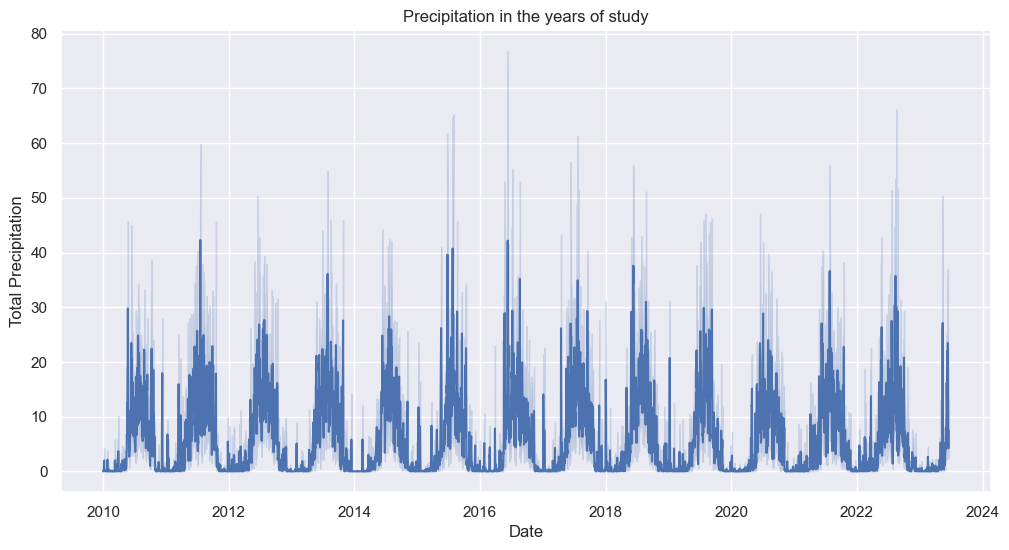

In [13]:
#plot for the precipitation columns to visually verify the stationary
sns.set(rc = {'figure.figsize':(12,6)})
g= sns.lineplot(data= data, x= 'time', y= 'precipitation_sum')
g.set_title('Precipitation in the years of study')
g.set_xlabel('Date')
g.set_ylabel('Total Precipitation')

In [15]:
#list of cities in the dataset
cities= list(data['city'].unique())
cities

['Yangoon',
 'Mandalay',
 'Nay Pyi Taw',
 'Hpa-An',
 'Maungdaw',
 'Taunggyi',
 'Magway',
 'Myeik',
 'Keng Tung',
 'Laukkaing']

In [16]:
#funcion
def forecasting_city(city):
        if city in cities:
                df = data.loc[data['city'] == city]
                df.reset_index(drop=True)
        
                return df       

In [37]:
df= forecasting_city('Myeik')
df.reset_index(drop=True)
print(df.head(), df.shape)

            time  weathercode  temperature_2m_max  temperature_2m_min  \
34412 2010-01-01            2                31.7                23.6   
34413 2010-01-02            3                32.9                23.3   
34414 2010-01-03            1                34.0                23.3   
34415 2010-01-04           53                32.7                23.8   
34416 2010-01-05           55                33.0                24.6   

       temperature_2m_mean  apparent_temperature_max  \
34412                 27.4                      36.7   
34413                 27.7                      38.3   
34414                 28.5                      38.7   
34415                 27.7                      36.9   
34416                 27.9                      38.4   

       apparent_temperature_min  apparent_temperature_mean  \
34412                      28.5                       31.9   
34413                      28.1                       32.2   
34414                      28.0       

We will divide our database into train and test. 

The test data will consist of the last 3 years and the rest to train the model.

One of the cities will be selected to perform the precipitation prediction.

In [33]:
# Prepare the data for NeuralProphet
#selecting the year for the train and test data
df_train_data = df[df['year'] <= 2019]
df_test_data= df[df['year'] >= 2020]


In [87]:
# Train-test split
train_data = df_train_data[['time', 'precipitation_sum']]
test_data = df_test_data[['time', 'precipitation_sum']]

train_data.columns= ['ds', 'y']
test_data.columns= ['ds', 'y']


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


  0%|          | 0/139 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 3.86E-01


  0%|          | 0/139 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.16E-01, min: 1.49E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.05E-01
Epoch[134/134]: 100%|██████████| 134/134 [00:35<00:00,  3.81it/s, SmoothL1Loss=0.0385, MAE=6.55, RMSE=9.93, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.921% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\Indatech\anaconda3\envs\weather_app_st\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.96% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_f

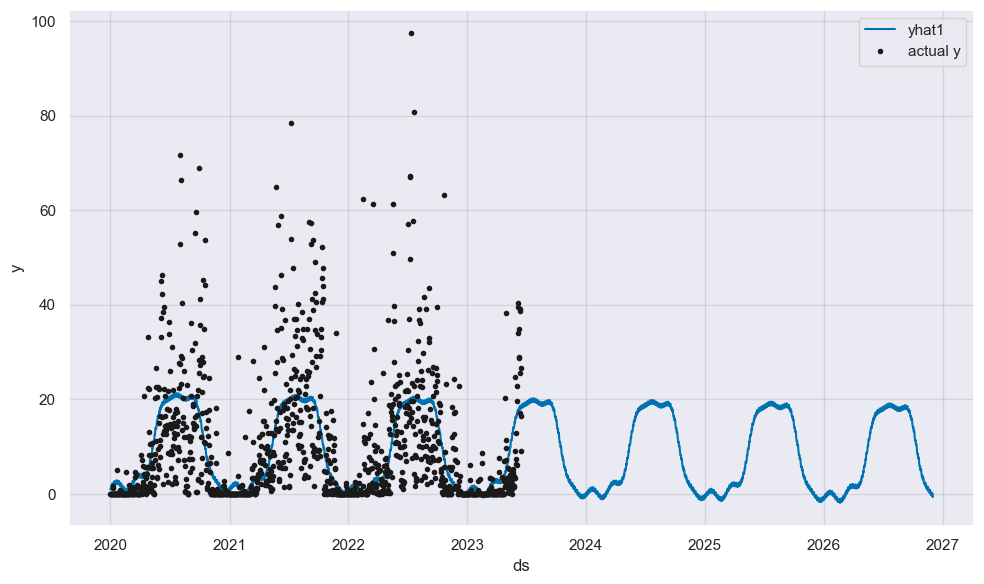

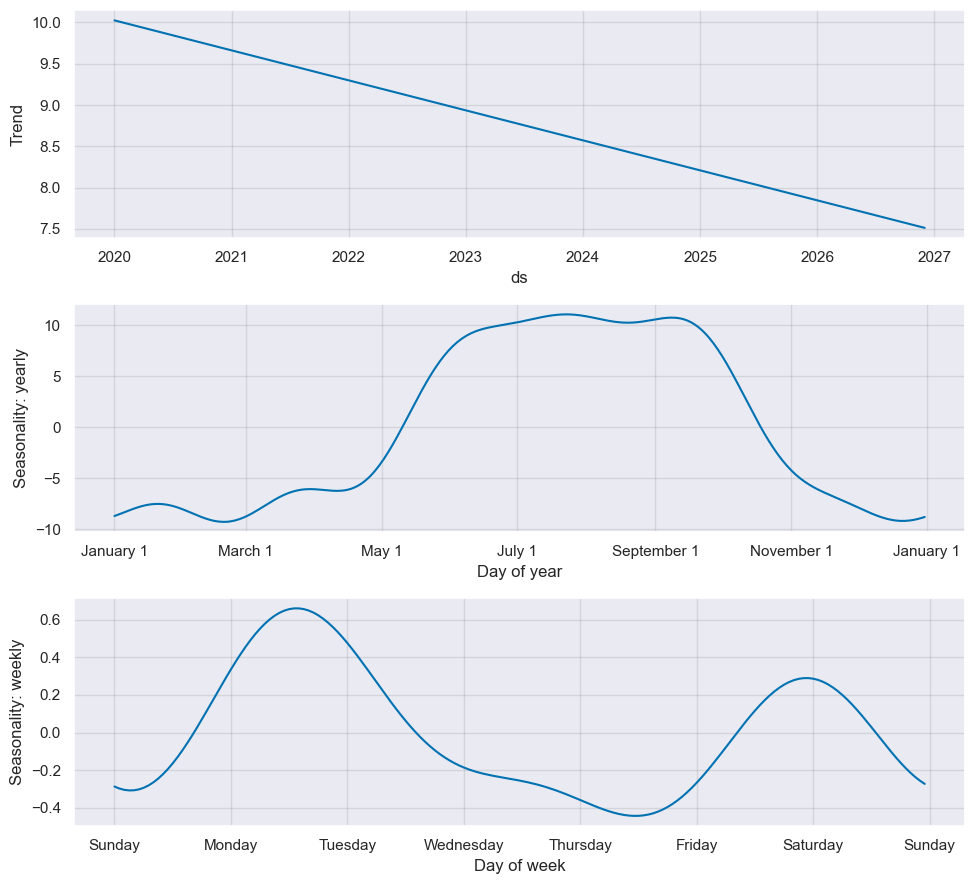

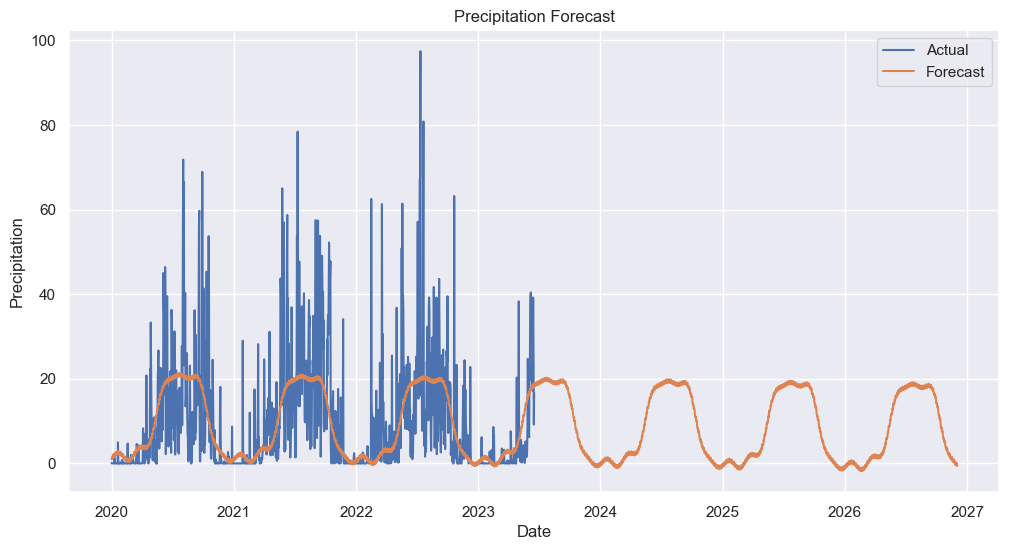

In [88]:
# Initialize the NeuralProphet model
model = NeuralProphet()

# Fit the model to the training data
model.fit(train_data)

# Generate forecasts for the testing period
future = model.make_future_dataframe(test_data, periods=test_data.shape[0], n_historic_predictions=len(test_data))
forecast = model.predict(future)

#ploting the forecast
plot_1 = model.plot(forecast)
plot_2 = model.plot_components(forecast)

# Plot the forecasted values and the actual values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data['ds'], test_data['y'], label='Actual')
ax.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.set_title('Precipitation Forecast')
ax.legend()
plt.show()


In [90]:
# Evaluate the model by comparing the forecasted values with the actual values
comparison = forecast.set_index('ds')[['yhat1']].join(test_data.set_index('ds')[['y']])
rmse = ((comparison['yhat1'] - comparison['y']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

RMSE: 11.05229914182217
